In [1]:
# Plotting imports
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from matplotlib.colors import ListedColormap

sns.set_style('white')

plt.rc('font', family='sans-serif')
plt.rc('font', serif='Arial')
plt.rc('text', usetex='false')

try:
    plt.style.use('../custom.mplstyle')
except IOError:
    plt.rc('font', size=10)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('axes', labelsize=12, titlesize=12)
    plt.rc('legend', fontsize=8)

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from ete3 import Tree

In [3]:
def get_tree(infile):
    tree = Tree(infile)

    for x in tree.traverse():
        if not x.is_leaf():
            continue
        x.name = x.name.replace("'", '').split('.')[0]
        if x.name == 'genome':
            x.name = 'NT12001_189'
    strains = {x.name.split('_')[0]
               for x in tree.traverse()
               if x.is_leaf()}
    for s in strains:
        nodes = sorted([x
                        for x in tree.traverse()
                        if x.name.startswith(s)],
                       key=lambda x: x.name)
        if len(nodes) == 1:
            continue
        for node in nodes[1:]:
            node.delete()
    for x in tree.traverse():
        if not x.is_leaf():
            continue
        x.name = x.name.split('_')[0]
    tree.set_outgroup(tree.get_midpoint_outgroup())

    return tree

In [4]:
tree = get_tree('../input/tree.nwk')

In [5]:
p = {x.split()[0].split('_')[0]: int(x.rstrip().split()[1])
     for x in open('../input/strains_nonsyn.txt')}
p1 = {x.split()[0].split('_')[0]: int(x.rstrip().split()[2])
      for x in open('../input/strains_pangenome.txt')}
p2 = {x.split()[0].split('_')[0]: int(x.rstrip().split()[3])
      for x in open('../input/strains_pangenome.txt')}

In [6]:
for x in tree.traverse():
    if not x.is_leaf():
        continue
    if x.name == 'NT12001':
        break
res = []
for y in tree.traverse():
    if not y.is_leaf():
        continue
    res.append((y.name,
                tree.get_distance(x, y),
                p.get(y.name),
                p1.get(y.name),
                p2.get(y.name)))
r = pd.DataFrame(res)
r.columns = ['strain', 'dist', 'nonsyn', 'genes', 'mgenes']
r = r.dropna()

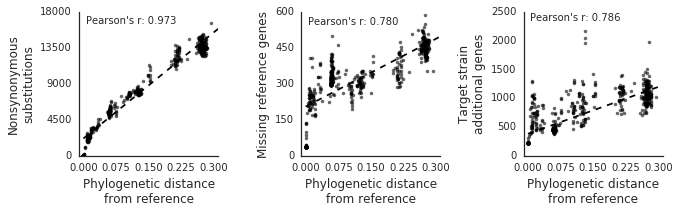

In [12]:
plt.figure(figsize=(9.5, 3))

plt.subplot(131)
l = stats.linregress(r['dist'],
                     r['nonsyn'])
plt.plot(r['dist'],
         r['nonsyn'],
         'k.',
         alpha=0.6,
         label='_')

fn = l.intercept + l.slope * np.linspace(0, 0.31)
plt.plot(np.linspace(0, 0.31),
         fn,
         'k--')

plt.ylabel('Nonsynonymous\nsubstitutions')
plt.xlabel('Phylogenetic distance\nfrom reference')

plt.xlim(-0.01, 0.31)

plt.text(0.005,
         16500,
         'Pearson\'s r: %.3f' % l.rvalue)

plt.xticks(np.linspace(0, 0.3, num=5))
plt.yticks([0, 4500, 9000, 13500, 18000])

plt.subplot(132)
l = stats.linregress(r['dist'],
                     r['genes'])
plt.plot(r['dist'],
         r['genes'],
         'k.',
         alpha=0.6,
         label='_')

fn = l.intercept + l.slope * np.linspace(0, 0.31)
plt.plot(np.linspace(0, 0.31),
         fn,
         'k--')

plt.ylabel('Missing reference genes')
plt.xlabel('Phylogenetic distance\nfrom reference')

plt.xlim(-0.01, 0.31)

plt.text(0.005,
         545,
         'Pearson\'s r: %.3f' % l.rvalue)

plt.xticks(np.linspace(0, 0.3, num=5))
plt.yticks([0, 150, 300, 450, 600])

plt.subplot(133)
l = stats.linregress(r['dist'],
                     r['mgenes'])
plt.plot(r['dist'],
         r['mgenes'],
         'k.',
         alpha=0.6,
         label='_')

fn = l.intercept + l.slope * np.linspace(0, 0.31)
plt.plot(np.linspace(0, 0.31),
         fn,
         'k--')

plt.ylabel('Target strain\nadditional genes')
plt.xlabel('Phylogenetic distance\nfrom reference')

plt.xlim(-0.01, 0.31)

plt.text(0.005,
         2350,
         'Pearson\'s r: %.3f' % l.rvalue)

plt.xticks(np.linspace(0, 0.3, num=5))
# plt.yticks([0, 400, 800, 1200, 1600])

sns.despine()
plt.tight_layout()
plt.savefig('sfig1.svg', dpi=150)

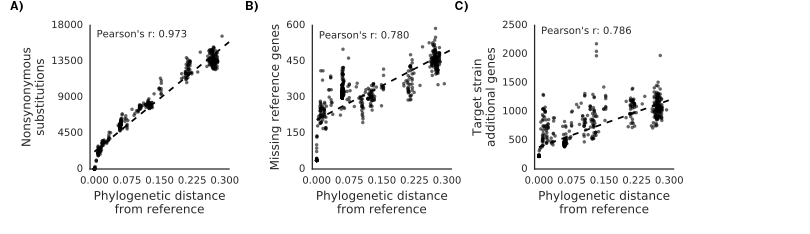

In [16]:
import svgutils.transform as sg
import sys 

#create new SVG figure
fig = sg.SVGFigure("9in", "2.6in")

# load matpotlib-generated figures
fig1 = sg.fromfile('sfig1.svg')

# get the plot objects
plot = fig1.getroot()
plot.moveto(10, 10, scale=1)

# add text labels
txt1 = sg.TextElement(10,  10, "A)", size=12, weight="bold")
txt2 = sg.TextElement(245, 10, "B)", size=12, weight="bold")
txt3 = sg.TextElement(455, 10, "C)", size=12, weight="bold")

# append plots and labels to figure
fig.append([plot])
fig.append([txt1, txt2, txt3])

# save generated SVG files
fig.save("../figures/supplementary/sfig1.svg")

!convert ../figures/supplementary/sfig1.svg sfig1.png

from IPython.display import Image
Image(filename='sfig1.png')